In [1]:
!pip install open_clip_torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import open_clip
import torchvision.models as models
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import timm


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coco-2017-dataset' dataset.
Path to dataset files: /kaggle/input/coco-2017-dataset


Teacher

In [4]:
import torch
import open_clip

# 1. Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🦖 Instantiating Teacher (ViT-B-16)...")

# 2. Load Model
# We try LAION-2B first (standard for modern reproduction), fallback to OpenAI if needed
try:
    teacher, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion2b_s34b_b88k', device=device)
    print("   ↳ Weights: LAION-2B (Loaded Successfully)")
except:
    teacher, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)
    print("   ↳ Weights: OpenAI (Fallback Loaded)")

# 3. Freeze Teacher (Crucial for KD)
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

# 4. Utilities
tokenizer = open_clip.get_tokenizer('ViT-B-16')

print(f"✅ Teacher variable 'teacher' is ready on {device}.")

🦖 Instantiating Teacher (ViT-B-16)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

   ↳ Weights: LAION-2B (Loaded Successfully)
✅ Teacher variable 'teacher' is ready on cuda.


Student

In [5]:
class StudentTextTransformer(nn.Module):
    def __init__(self, vocab_size=49408, width=384, layers=12, heads=6, output_dim=512):
        super().__init__()
        self.width = width
        self.token_embedding = nn.Embedding(vocab_size, width)
        self.positional_embedding = nn.Parameter(torch.empty(77, width))

        # Use a proper Transformer (CLIP style)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=width,
            nhead=heads,
            batch_first=True,
            norm_first=True,
            activation="gelu",
            dropout=0.0 # Standard CLIP doesn't use dropout during inference/KD
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.ln_final = nn.LayerNorm(width)
        self.text_projection = nn.Parameter(torch.empty(width, output_dim))

        # Register causal mask to ensure identical behavior to MobileViT run
        mask = torch.triu(torch.ones(77, 77) * float('-inf'), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, input_ids):
        # 1. Embeddings
        x = self.token_embedding(input_ids) + self.positional_embedding

        # 2. Apply Causal Mask (Ensures same 'direction' as MobileViT transformer)
        x = self.transformer(x, mask=self.mask)

        # 3. Final Norm and Pooling
        x = self.ln_final(x)
        # Pool at the [EOT] token position
        x = x[torch.arange(x.shape[0]), input_ids.argmax(dim=-1)]
        return x @ self.text_projection

class MobileCLIPStudent(nn.Module):
    def __init__(self):
        super().__init__()
        # MobileNetV3-Small
        self.vision = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        vis_dim = self.vision.classifier[0].in_features
        self.vision.classifier = nn.Identity()
        self.visual_proj = nn.Linear(vis_dim, 512, bias=False)

        # Transformer (Ensures exact same capacity as your MobileViT text side)
        self.text = StudentTextTransformer(width=384, layers=12, heads=6)
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

    def forward(self, images, input_ids):
        v = self.visual_proj(self.vision(images))
        v = v / v.norm(dim=-1, keepdim=True)

        t = self.text(input_ids)
        t = t / t.norm(dim=-1, keepdim=True)

        return v, t, self.logit_scale.exp()

In [6]:
import torch
import torch.nn as nn
from torchvision import models

class StudentTextTransformer(nn.Module):
    def __init__(self, vocab_size=49408, width=384, layers=12, heads=6, output_dim=512):
        super().__init__()
        self.width = width
        self.token_embedding = nn.Embedding(vocab_size, width)
        self.positional_embedding = nn.Parameter(torch.empty(77, width))

        # Use a proper Transformer (CLIP style)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=width,
            nhead=heads,
            batch_first=True,
            norm_first=True,
            activation="gelu",
            dropout=0.0
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.ln_final = nn.LayerNorm(width)
        self.text_projection = nn.Parameter(torch.empty(width, output_dim))

        # Register causal mask
        mask = torch.triu(torch.ones(77, 77) * float('-inf'), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, input_ids):
        # 1. Embeddings
        x = self.token_embedding(input_ids) + self.positional_embedding

        # 2. Apply Causal Mask
        x = self.transformer(x, mask=self.mask)

        # 3. Final Norm and Pooling
        x = self.ln_final(x)
        x = x[torch.arange(x.shape[0]), input_ids.argmax(dim=-1)]
        return x @ self.text_projection

class ResNetCLIPStudent(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        # --- VISION BACKBONE (ResNet18) ---
        self.vision = models.resnet18(weights='IMAGENET1K_V1')

        # ResNet stores the final classifier in a layer named 'fc'.
        # We grab its input dimension (512 for ResNet18) before replacing it.
        vis_dim = self.vision.fc.in_features

        # Replace the classification head with Identity to get raw features
        self.vision.fc = nn.Identity()

        # Project from ResNet feature dimension (512) to CLIP embedding dimension (512)
        self.visual_proj = nn.Linear(vis_dim, output_dim, bias=False)

        # --- TEXT BACKBONE ---
        self.text = StudentTextTransformer(width=384, layers=12, heads=6, output_dim=output_dim)

        # Learnable Temperature
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

    def forward(self, images, input_ids):
        # Vision Forward
        # self.vision(images) returns (Batch, 512) because fc is Identity
        v = self.visual_proj(self.vision(images))
        v = v / v.norm(dim=-1, keepdim=True)

        # Text Forward
        t = self.text(input_ids)
        t = t / t.norm(dim=-1, keepdim=True)

        return v, t, self.logit_scale.exp()

In [7]:
import copy

# --- 1. Helper: Initialization Function ---
def initialize_weights(student_model, teacher_model):
    """
    Slices the Teacher's 512-dim embeddings to fit the Student's 384-dim width.
    This gives the student a 'head start' on language understanding.
    """
    s_width = 384
    with torch.no_grad():
        # 1. Slice Token Embeddings [Vocab, 512] -> [Vocab, 384]
        student_model.text.token_embedding.weight.copy_(
            teacher_model.token_embedding.weight.data[:, :s_width]
        )

        # 2. Slice Positional Embeddings [77, 512] -> [77, 384]
        student_model.text.positional_embedding.copy_(
            teacher_model.positional_embedding.data[:, :s_width]
        )

        # 3. Slice Text Projection [512, 512] -> [384, 512]
        # Note: We take the first 384 rows of the teacher's projection matrix
        student_model.text.text_projection.copy_(
            teacher_model.text_projection.data[:s_width, :]
        )

        # 4. Sync Logit Scale
        student_model.logit_scale.copy_(teacher_model.logit_scale.data)

    return student_model

# --- 2. Instantiate & Initialize Master ---
print("🚀 Instantiating Master Student...")
master_student = MobileCLIPStudent().to(device)
master_student = initialize_weights(master_student, teacher)

print(f"   ✅ Master initialized. Logit Scale: {master_student.logit_scale.exp().item():.3f}")

# --- 3. Clone into 6 Identical Students ---
print("👯 Cloning 6 Identical Students...")

student       = copy.deepcopy(master_student)  # Standard KD (Baseline)
student_white = copy.deepcopy(master_student)  # Joint Whitened KD

raw_icl       = copy.deepcopy(master_student)  # Raw ICL (No Distill, just Contrastive)
icl_white     = copy.deepcopy(master_student)  # Whitened ICL

raw_fd        = copy.deepcopy(master_student)  # Raw Feature Distillation (FD Only)
fd_white      = copy.deepcopy(master_student)  # Whitened Feature Distillation (FD Only)

# Verify they are separate objects
assert student is not student_white
assert student.text.transformer is not student_white.text.transformer

print("✅ All 6 Students are ready (Identical Initialization).")
print(f"   Names: student, student_white, raw_icl, icl_white, raw_fd, fd_white")

🚀 Instantiating Master Student...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 201MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


   ✅ Master initialized. Logit Scale: 100.000
👯 Cloning 6 Identical Students...
✅ All 6 Students are ready (Identical Initialization).
   Names: student, student_white, raw_icl, icl_white, raw_fd, fd_white


In [8]:
import copy
import torch

# --- 1. Helper: Initialization Function ---
def initialize_weights(student_model, teacher_model):
    """
    Slices the Teacher's 512-dim embeddings to fit the Student's 384-dim width.
    This gives the student a 'head start' on language understanding.
    """
    s_width = 384
    with torch.no_grad():
        # 1. Slice Token Embeddings [Vocab, 512] -> [Vocab, 384]
        student_model.text.token_embedding.weight.copy_(
            teacher_model.token_embedding.weight.data[:, :s_width]
        )

        # 2. Slice Positional Embeddings [77, 512] -> [77, 384]
        student_model.text.positional_embedding.copy_(
            teacher_model.positional_embedding.data[:, :s_width]
        )

        # 3. Slice Text Projection [512, 512] -> [384, 512]
        # We take the first 384 rows of the teacher's projection matrix to match student width
        student_model.text.text_projection.copy_(
            teacher_model.text_projection.data[:s_width, :]
        )

        # 4. Sync Logit Scale
        student_model.logit_scale.copy_(teacher_model.logit_scale.data)

    return student_model

# --- 2. Instantiate & Initialize Master (ResNet18) ---
print("🚀 Instantiating Master ResNet18 Student...")
master_student_r18 = ResNetCLIPStudent().to(device)
master_student_r18 = initialize_weights(master_student_r18, teacher)

print(f"   ✅ Master ResNet18 initialized. Logit Scale: {master_student_r18.logit_scale.exp().item():.3f}")

# --- 3. Clone into 6 Identical Students ---
print("👯 Cloning 6 Identical ResNet18 Students...")

student_r18       = copy.deepcopy(master_student_r18)  # Standard KD (Baseline)
student_white_r18 = copy.deepcopy(master_student_r18)  # Joint Whitened KD

raw_icl_r18       = copy.deepcopy(master_student_r18)  # Raw ICL (No Distill, just Contrastive)
icl_white_r18     = copy.deepcopy(master_student_r18)  # Whitened ICL

raw_fd_r18        = copy.deepcopy(master_student_r18)  # Raw Feature Distillation (FD Only)
fd_white_r18      = copy.deepcopy(master_student_r18)  # Whitened Feature Distillation (FD Only)

# Verify they are separate objects
assert student_r18 is not student_white_r18
assert student_r18.text.transformer is not student_white_r18.text.transformer

print("✅ All 6 ResNet18 Students are ready (Identical Initialization).")
print(f"   Names: student_r18, student_white_r18, raw_icl_r18, icl_white_r18, raw_fd_r18, fd_white_r18")

🚀 Instantiating Master ResNet18 Student...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 230MB/s]


   ✅ Master ResNet18 initialized. Logit Scale: 100.000
👯 Cloning 6 Identical ResNet18 Students...
✅ All 6 ResNet18 Students are ready (Identical Initialization).
   Names: student_r18, student_white_r18, raw_icl_r18, icl_white_r18, raw_fd_r18, fd_white_r18


In [31]:
student       = copy.deepcopy(master_student)  # Standard KD (Baseline)
student_white = copy.deepcopy(master_student)  # Joint Whitened KD

raw_icl       = copy.deepcopy(master_student)  # Raw ICL (No Distill, just Contrastive)
icl_white     = copy.deepcopy(master_student)  # Whitened ICL

raw_fd        = copy.deepcopy(master_student)  # Raw Feature Distillation (FD Only)
fd_white      = copy.deepcopy(master_student)  # Whitened Feature Distillation (FD Only)

# Verify they are separate objects
assert student is not student_white
assert student.text.transformer is not student_white.text.transformer

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions
import numpy as np
from tqdm import tqdm
import os

# --- 1. Kaggle Path Configuration ---
root_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
json_file = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# --- 2. Base Dataset Class ---
class BaseCOCODataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, ann_file, preprocess, tokenizer):
        super().__init__()
        self.root = root_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer

        # Standard COCO helper
        self.coco = CocoCaptions(root=root_dir, annFile=ann_file)
        self.ids = list(sorted(self.coco.coco.imgs.keys()))

    def __getitem__(self, index):
        coco_id = self.ids[index]
        img_metadata = self.coco.coco.loadImgs(coco_id)[0]
        path = os.path.join(self.root, img_metadata['file_name'])

        # Load and Preprocess
        raw_img = Image.open(path).convert('RGB')
        img_tensor = self.preprocess(raw_img)

        # Tokenize first caption
        anns = self.coco.coco.loadAnns(self.coco.coco.getAnnIds(imgIds=coco_id))
        caption = anns[0]['caption']
        text_tokens = self.tokenizer([caption])[0]

        return img_tensor, text_tokens

    def __len__(self):
        return len(self.ids)

# --- 3. Initialize Base Loader ---
# Shuffle=False is mandatory to keep indices aligned for .npy saving
base_coco_dataset = BaseCOCODataset(root_dir, json_file, preprocess, tokenizer)
base_coco_loader = DataLoader(
    base_coco_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

loading annotations into memory...
Done (t=1.74s)
creating index...
index created!


In [11]:
# 1. Prepare Teacher
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher.to(device)
teacher.eval()

all_img_embeds = []
all_txt_embeds = []

print("🚀 Generating Teacher Embeddings...")

with torch.no_grad():
    for images, texts in tqdm(base_coco_loader):
        images = images.to(device)
        texts = texts.to(device)

        # encode_image/text returns the 512-D projection
        img_feats = teacher.encode_image(images)
        txt_feats = teacher.encode_text(texts)

        # We keep them raw (no l2_norm yet) for the Whitening step
        all_img_embeds.append(img_feats.cpu().numpy())
        all_txt_embeds.append(txt_feats.cpu().numpy())

# 2. Save to Kaggle /working directory
img_emb_final = np.concatenate(all_img_embeds, axis=0)
txt_emb_final = np.concatenate(all_txt_embeds, axis=0)

np.save('teacher_img_embeds.npy', img_emb_final)
np.save('teacher_txt_embeds.npy', txt_emb_final)

print(f"✅ Success! Generated {img_emb_final.shape[0]} pairs.")
print(f"📍 Saved to: /kaggle/working/teacher_img_embeds.npy")

🚀 Generating Teacher Embeddings...


100%|██████████| 463/463 [08:15<00:00,  1.07s/it]


✅ Success! Generated 118287 pairs.
📍 Saved to: /kaggle/working/teacher_img_embeds.npy


In [12]:
import torch
import numpy as np

def compute_zca_stats(features_npy_path):
    # 1. Load the raw features
    features = np.load(features_npy_path)

    # 2. Compute Mean
    mu = np.mean(features, axis=0)

    # 3. Center the data
    centered_features = features - mu

    # 4. Compute Covariance Matrix
    # Using (N-1) for an unbiased estimator
    n_samples = features.shape[0]
    covariance_matrix = (centered_features.T @ centered_features) / (n_samples - 1)

    # 5. Singular Value Decomposition (SVD) for ZCA
    U, S, Vh = np.linalg.svd(covariance_matrix)

    # 6. Apply epsilon for numerical stability
    # This prevents division by zero in near-null dimensions
    epsilon = 1e-5

    # 7. ZCA Whitening Matrix Formula: W = U * diag(1/sqrt(S + eps)) * U.T
    # This transforms the data to have Identity covariance while maintaining spatial alignment
    whitening_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T

    # Convert to torch tensors and move to GPU for the training loop
    return (
        torch.from_numpy(mu).float().cuda(),
        torch.from_numpy(whitening_matrix).float().cuda()
    )

# --- EXECUTION ---
print("⚙️ Computing Separate ZCA Statistics...")

# Compute for Vision
mu_img, W_img = compute_zca_stats('teacher_img_embeds.npy')

# Compute for Text
mu_txt, W_txt = compute_zca_stats('teacher_txt_embeds.npy')

print(f"✅ Statistics generated.")
print(f"   Vision stats shape: mu {mu_img.shape}, W {W_img.shape}")
print(f"   Text stats shape:   mu {mu_txt.shape}, W {W_txt.shape}")

⚙️ Computing Separate ZCA Statistics...
✅ Statistics generated.
   Vision stats shape: mu torch.Size([512]), W torch.Size([512, 512])
   Text stats shape:   mu torch.Size([512]), W torch.Size([512, 512])


In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Standard CIFAR-10 Dataset
# We use the teacher's preprocess (from open_clip) to ensure 224x224 and correct normalization
cifar_test_set = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=preprocess # This is the teacher's visual preprocess
)

# 2. Define the Loader
# Batch size can be 128 or 256 depending on your VRAM
cifar_loader = DataLoader(
    cifar_test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ CIFAR-10 Loader defined with {len(cifar_test_set)} images.")

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


✅ CIFAR-10 Loader defined with 10000 images.


In [14]:
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

@torch.no_grad()
def evaluate_whitened_teacher_accuracy(model, loader, tokenizer, mu_img, W_img, mu_txt, W_txt):
    model.eval()
    device = next(model.parameters()).device

    # 1. Prepare Text Classifier (Whitened & Re-normalized)
    # CIFAR-10 Classes
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    prompts = [f"a photo of a {name}" for name in class_names]
    tokens = tokenizer(prompts).to(device)

    # Get raw teacher text features
    text_features = model.encode_text(tokens) # [10, 512]

    # Apply Separate Text Whitening
    text_features = (text_features - mu_txt) @ W_txt

    # CRITICAL: Re-normalize to unit sphere
    text_features = F.normalize(text_features, p=2, dim=-1)

    # 2. Inference Loop
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Get raw teacher image features
        image_features = model.encode_image(images) # [Batch, 512]

        # Apply Separate Image Whitening
        image_features = (image_features - mu_img) @ W_img

        # CRITICAL: Re-normalize to unit sphere
        image_features = F.normalize(image_features, p=2, dim=-1)

        # 3. Calculate Similarity (Cosine)
        # We use the logit scale standard to CLIP models
        logits = image_features @ text_features.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = (correct / total) * 100
    return accuracy

# --- EXECUTION ---
# Ensure your cifar_loader is initialized with the teacher's preprocess
print("🔍 Running Sanity Check: Whitened Teacher on CIFAR-10...")
accuracy = evaluate_whitened_teacher_accuracy(
    teacher, cifar_loader, tokenizer,
    mu_img, W_img, mu_txt, W_txt
)

print(f"✅ Whitened Teacher CIFAR-10 Accuracy: {accuracy:.2f}%")

🔍 Running Sanity Check: Whitened Teacher on CIFAR-10...
✅ Whitened Teacher CIFAR-10 Accuracy: 61.53%


Student Dataset

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoCaptions
from PIL import Image
import numpy as np
import os

class StudentDistillationDataset(Dataset):
    def __init__(self, root_dir, ann_file, img_npy_path, txt_npy_path, preprocess, tokenizer):
        super().__init__()
        self.root = root_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer

        # 1. Load the COCO metadata
        self.coco = CocoCaptions(root=root_dir, annFile=ann_file)
        self.ids = list(sorted(self.coco.coco.imgs.keys()))

        # 2. Load the RAW teacher embeddings (pre-ZCA)
        print(f"⌛ Loading Teacher targets from {img_npy_path}...")
        self.t_img_embeds = torch.from_numpy(np.load(img_npy_path)).float()
        self.t_txt_embeds = torch.from_numpy(np.load(txt_npy_path)).float()

        # 3. Validation: Ensure embeddings match metadata count
        if len(self.ids) != len(self.t_img_embeds):
            raise ValueError(f"Mismatch! Dataset has {len(self.ids)} images, "
                             f"but found {len(self.t_img_embeds)} embeddings.")

    def __getitem__(self, index):
        # --- Student Inputs ---
        coco_id = self.ids[index]
        img_metadata = self.coco.coco.loadImgs(coco_id)[0]
        path = os.path.join(self.root, img_metadata['file_name'])

        # Load image for student visual encoder
        raw_img = Image.open(path).convert('RGB')
        img_tensor = self.preprocess(raw_img)

        # Load caption for student text encoder
        anns = self.coco.coco.loadAnns(self.coco.coco.getAnnIds(imgIds=coco_id))
        caption = anns[0]['caption']
        text_tokens = self.tokenizer([caption])[0]

        # --- Teacher Targets (Raw Projections) ---
        t_img = self.t_img_embeds[index]
        t_txt = self.t_txt_embeds[index]

        return img_tensor, text_tokens, t_img, t_txt

    def __len__(self):
        return len(self.ids)

# --- Initialize the Loader ---
# Point to the raw .npy files we generated earlier
img_npy = '/content/teacher_img_embeds.npy'
txt_npy = '/content/teacher_txt_embeds.npy'

student_dataset = StudentDistillationDataset(
    root_dir=root_dir,
    ann_file=json_file,
    img_npy_path=img_npy,
    txt_npy_path=txt_npy,
    preprocess=preprocess, # Ensure this matches student input requirements
    tokenizer=tokenizer
)

# shuffle=True is vital for effective contrastive learning
student_loader = DataLoader(
    student_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"✅ student_loader initialized with {len(student_dataset)} samples.")

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
⌛ Loading Teacher targets from /content/teacher_img_embeds.npy...
✅ student_loader initialized with 118287 samples.


Training

In [16]:
import torch
import torch.nn.functional as F

def icl_loss(s_img_emb, s_txt_emb, t_img_emb, t_txt_emb, temperature=0.07):
    """
    Interactive Contrastive Loss (ICL)
    Aligns Student features with Teacher features using Contrastive Learning.
    Matches Eq (14), (15), (16) from the paper.
    """
    # 1. Define Labels
    # In Batchwise InfoNCE, the 'label' is just the index of the pair.
    # Row 0 matches Column 0, Row 1 matches Column 1, etc.
    batch_size = s_img_emb.shape[0]
    labels = torch.arange(batch_size, device=s_img_emb.device)

    # 2. Equation (14): Image-to-Text Direction
    # "Given Student Image, find the correct Teacher Text"
    # Matrix Shape: [Batch x Batch]
    logits_ItoT = (s_img_emb @ t_txt_emb.T) / temperature
    loss_ItoT = F.cross_entropy(logits_ItoT, labels)

    # 3. Equation (15): Text-to-Image Direction
    # "Given Student Text, find the correct Teacher Image"
    # Matrix Shape: [Batch x Batch]
    logits_TtoI = (s_txt_emb @ t_img_emb.T) / temperature
    loss_TtoI = F.cross_entropy(logits_TtoI, labels)

    # 4. Equation (16): Average both directions
    return (loss_ItoT + loss_TtoI) / 2
    loss_ItoT = F.cross_entropy(logits_ItoT, labels)

    # Eq (15): ICL Text-to-Image
    loss_TtoI = F.cross_entropy(logits_TtoI, labels)

    # 4. Eq (16): Total ICL is the average
    return (loss_ItoT + loss_TtoI) / 2

print("✅ ICL Loss Refined: Matrix multiplication between Student and Teacher.")

✅ ICL Loss Refined: Matrix multiplication between Student and Teacher.


In [17]:
import torch.nn.functional as F

def info_nce_loss(image_embeddings, text_embeddings, temperature=0.07):
    """
    Standard Symmetric CLIP Loss
    """
    # 1. Matrix Multiplication to get Similarity Matrix (Logits)
    # [Batch, Dim] @ [Dim, Batch] -> [Batch, Batch]
    logits_per_image = (image_embeddings @ text_embeddings.T) / temperature
    logits_per_text = logits_per_image.T

    # 2. Create Ground Truth Labels (Diagonal)
    # Each image at index i matches text at index i
    labels = torch.arange(image_embeddings.shape[0], device=image_embeddings.device)

    # 3. Calculate I2T and T2I Cross Entropy
    loss_i2t = F.cross_entropy(logits_per_image, labels)
    loss_t2i = F.cross_entropy(logits_per_text, labels)

    # 4. Return Symmetric Average
    return (loss_i2t + loss_t2i) / 2

def fd_loss(student_embeddings, teacher_embeddings):
    """
    Feature Distillation (MSE) Loss
    Ensures the Student mimics the Teacher's output vectors
    """
    return F.mse_loss(student_embeddings, teacher_embeddings)

print("✅ Loss Functions Defined: InfoNCE (I2T/T2I) and FD (MSE)")

✅ Loss Functions Defined: InfoNCE (I2T/T2I) and FD (MSE)


In [18]:
def evaluate_on_cifar(student_model, loader, device):
    """
    Evaluates Zero-Shot CIFAR-10 Accuracy using the Student's own Text Encoder.
    """
    student_model.eval()
    correct = 0
    total = 0

    # 1. Prepare Text Anchors (Using specific prompt template)
    cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    prompts = [f"Image of a {c}" for c in cifar_classes]

    with torch.no_grad():
        # Tokenize
        tokenizer = open_clip.get_tokenizer('ViT-B-16')
        tokens = tokenizer(prompts).to(device)

        # Encode with STUDENT'S Text Encoder
        # The StudentTextTransformer returns raw features, so we normalize manually
        text_anchors = student_model.text(tokens)
        text_anchors = text_anchors / text_anchors.norm(dim=-1, keepdim=True)

    # 2. Inference Loop
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Encode with STUDENT'S Image Encoder
            # (MobileNet -> Proj -> Norm)
            # We access components directly to avoid passing dummy text to .forward()
            img_feats = student_model.vision(images)
            img_feats = student_model.visual_proj(img_feats)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            # 3. Classification
            logits = 100.0 * img_feats @ text_anchors.t()
            preds = logits.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100.0 * correct / total

🥊 STARTING BATTLE: ResNet18 Raw vs. ResNet18 White
   Structure: Loss = InfoNCE + ICL + 2000.0 * FD_MSE


Epoch 1/5: 100%|██████████| 463/463 [05:07<00:00,  1.51it/s, R_Tot=9.36, W_Tot=14.69, R_FD=0.0022, W_FD=0.0051, R_ICL=2.21, W_ICL=2.78]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 1 RESULTS (ResNet18)
   🟡 Student (Raw) Accuracy:      48.97%
   ⚪ Student (White) Accuracy:    57.15%
----------------------------------------


Epoch 2/5: 100%|██████████| 463/463 [05:07<00:00,  1.51it/s, R_Tot=8.16, W_Tot=13.23, R_FD=0.0019, W_FD=0.0047, R_ICL=1.97, W_ICL=2.54]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 2 RESULTS (ResNet18)
   🟡 Student (Raw) Accuracy:      48.29%
   ⚪ Student (White) Accuracy:    55.91%
----------------------------------------


Epoch 3/5: 100%|██████████| 463/463 [05:07<00:00,  1.51it/s, R_Tot=7.28, W_Tot=12.28, R_FD=0.0018, W_FD=0.0044, R_ICL=1.61, W_ICL=2.34]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 3 RESULTS (ResNet18)
   🟡 Student (Raw) Accuracy:      46.70%
   ⚪ Student (White) Accuracy:    56.85%
----------------------------------------


Epoch 4/5: 100%|██████████| 463/463 [05:08<00:00,  1.50it/s, R_Tot=6.43, W_Tot=11.50, R_FD=0.0017, W_FD=0.0042, R_ICL=1.21, W_ICL=2.23]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 4 RESULTS (ResNet18)
   🟡 Student (Raw) Accuracy:      54.01%
   ⚪ Student (White) Accuracy:    57.27%
----------------------------------------


Epoch 5/5: 100%|██████████| 463/463 [05:10<00:00,  1.49it/s, R_Tot=5.90, W_Tot=10.88, R_FD=0.0017, W_FD=0.0040, R_ICL=1.03, W_ICL=2.10]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 5 RESULTS (ResNet18)
   🟡 Student (Raw) Accuracy:      56.71%
   ⚪ Student (White) Accuracy:    56.96%
----------------------------------------
📈 Plotting Loss Curves...


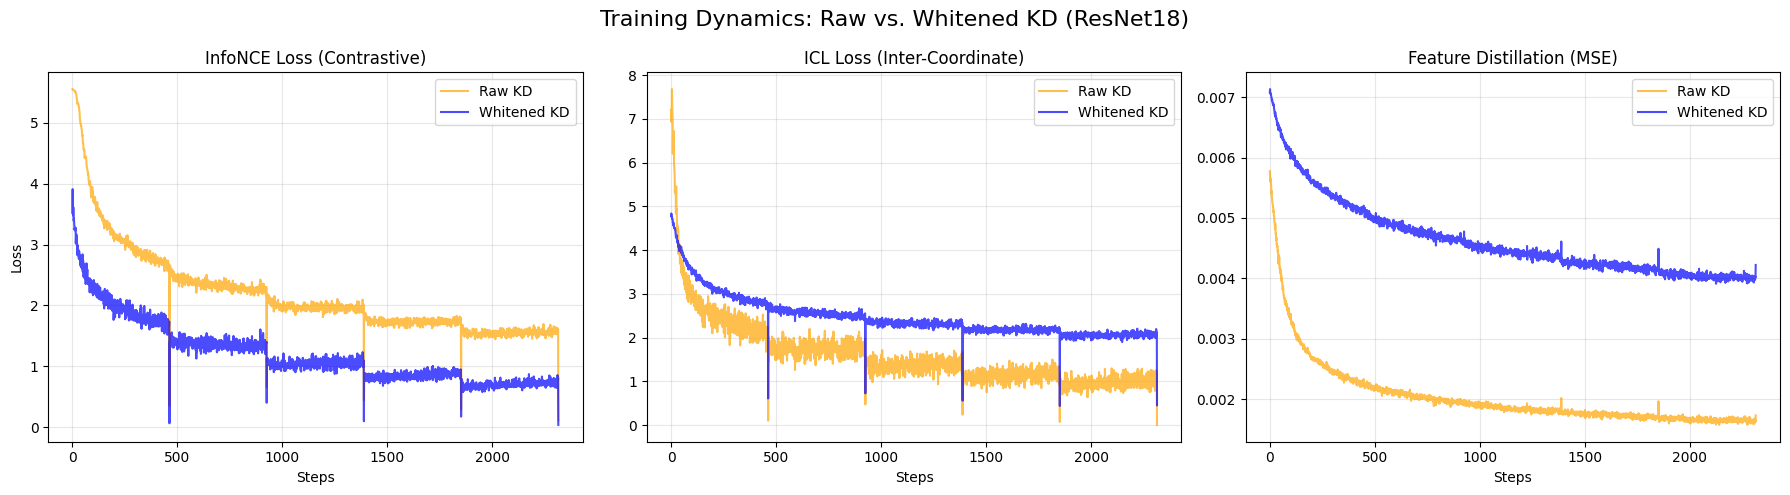

In [21]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- CONFIGURATION ---
EPOCHS = 5
ALPHA = 2000.0  # Weight for FD Loss
LR = 1e-4

# 1. Setup Optimizers (For ResNet Models)
opt_raw   = optim.AdamW(student_r18.parameters(), lr=LR, weight_decay=0.1)
opt_white = optim.AdamW(student_white_r18.parameters(), lr=LR, weight_decay=0.1)

# 2. Setup History Storage
history = {
    "raw":   {"nce": [], "icl": [], "fd": [], "total": []},
    "white": {"nce": [], "icl": [], "fd": [], "total": []}
}

# 3. Training Loop
print(f"🥊 STARTING BATTLE: ResNet18 Raw vs. ResNet18 White")
print(f"   Structure: Loss = InfoNCE + ICL + {ALPHA} * FD_MSE")

# Ensure whitening matrices are on the correct device
W_img, mean_img = W_img.to(device), mu_img.to(device)
W_txt, mean_txt = W_txt.to(device), mu_txt.to(device)

for epoch in range(EPOCHS):
    student_r18.train()
    student_white_r18.train()

    # Progress Bar
    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (imgs, tokens, t_img_raw, t_txt_raw) in enumerate(pbar):
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_img_raw, t_txt_raw = t_img_raw.to(device), t_txt_raw.to(device)

        # ==========================================
        # 🟡 1. TRAIN RAW STUDENT (Baseline)
        # ==========================================
        s_v, s_t, scale = student_r18(imgs, tokens)

        # Individual Components
        loss_nce = info_nce_loss(s_v, s_t)
        loss_icl = icl_loss(s_v, s_t, t_img_raw, t_txt_raw)

        # FD (Standardized) - Teacher Raw vs Student Raw
        fd_v = fd_loss(F.normalize(s_v, dim=-1), F.normalize(t_img_raw, dim=-1))
        fd_t = fd_loss(F.normalize(s_t, dim=-1), F.normalize(t_txt_raw, dim=-1))
        loss_fd = fd_v + fd_t

        total_loss_raw = loss_nce + loss_icl + (ALPHA * loss_fd)

        # Optimization
        opt_raw.zero_grad()
        total_loss_raw.backward()
        opt_raw.step()

        # Store Raw History
        history["raw"]["nce"].append(loss_nce.item())
        history["raw"]["icl"].append(loss_icl.item())
        history["raw"]["fd"].append(loss_fd.item())
        history["raw"]["total"].append(total_loss_raw.item())

        # ==========================================
        # ⚪ 2. TRAIN WHITENED STUDENT (Ours)
        # ==========================================
        # Pre-Whiten Teacher Targets
        with torch.no_grad():
            # Apply (x - mu) @ W
            t_img_white = F.normalize((t_img_raw - mean_img) @ W_img, p=2, dim=-1)
            t_txt_white = F.normalize((t_txt_raw - mean_txt) @ W_txt, p=2, dim=-1)

        sw_v, sw_t, scale_w = student_white_r18(imgs, tokens)

        # Individual Components
        loss_nce_w = info_nce_loss(sw_v, sw_t)
        loss_icl_w = icl_loss(sw_v, sw_t, t_img_white, t_txt_white)

        # FD (Whitened Targets) - Teacher White vs Student White
        # Note: Student output is ALREADY in the "Whitened" space implicitly because
        # we are training it to match whitened targets.
        fd_v_w = fd_loss(F.normalize(sw_v, dim=-1), t_img_white)
        fd_t_w = fd_loss(F.normalize(sw_t, dim=-1), t_txt_white)
        loss_fd_w = fd_v_w + fd_t_w

        total_loss_white = loss_nce_w + loss_icl_w + (ALPHA * loss_fd_w)

        # Optimization
        opt_white.zero_grad()
        total_loss_white.backward()
        opt_white.step()

        # Store White History
        history["white"]["nce"].append(loss_nce_w.item())
        history["white"]["icl"].append(loss_icl_w.item())
        history["white"]["fd"].append(loss_fd_w.item())
        history["white"]["total"].append(total_loss_white.item())

        # ==========================================
        # 📝 UPDATE PROGRESS BAR
        # ==========================================
        if batch_idx % 10 == 0:
            pbar.set_postfix({
                "R_Tot": f"{total_loss_raw.item():.2f}",
                "W_Tot": f"{total_loss_white.item():.2f}",
                "R_FD": f"{loss_fd.item():.4f}",
                "W_FD": f"{loss_fd_w.item():.4f}",
                "R_ICL": f"{loss_icl.item():.2f}",
                "W_ICL": f"{loss_icl_w.item():.2f}",
            })

    # ==========================================
    # 📊 END OF EPOCH EVALUATION
    # ==========================================
    print("\n⏱️ Epoch Finished. Running Evaluation...")

    # Assuming evaluate_on_cifar is defined as before
    acc_raw = evaluate_on_cifar(student_r18, cifar_loader, device)
    acc_white = evaluate_on_cifar(student_white_r18, cifar_loader, device)

    print("-" * 40)
    print(f"🏆 EPOCH {epoch+1} RESULTS (ResNet18)")
    print(f"   🟡 Student (Raw) Accuracy:      {acc_raw:.2f}%")
    print(f"   ⚪ Student (White) Accuracy:    {acc_white:.2f}%")
    print("-" * 40)

# --- 4. Plotting All Losses ---
print("📈 Plotting Loss Curves...")

def plot_losses(history):
    epochs_range = range(len(history["raw"]["nce"]))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Training Dynamics: Raw vs. Whitened KD (ResNet18)', fontsize=16)

    # 1. InfoNCE Loss
    axes[0].plot(history["raw"]["nce"], label="Raw KD", color='orange', alpha=0.7)
    axes[0].plot(history["white"]["nce"], label="Whitened KD", color='blue', alpha=0.7)
    axes[0].set_title("InfoNCE Loss (Contrastive)")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. ICL Loss
    axes[1].plot(history["raw"]["icl"], label="Raw KD", color='orange', alpha=0.7)
    axes[1].plot(history["white"]["icl"], label="Whitened KD", color='blue', alpha=0.7)
    axes[1].set_title("ICL Loss (Inter-Coordinate)")
    axes[1].set_xlabel("Steps")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. FD Loss
    axes[2].plot(history["raw"]["fd"], label="Raw KD", color='orange', alpha=0.7)
    axes[2].plot(history["white"]["fd"], label="Whitened KD", color='blue', alpha=0.7)
    axes[2].set_title("Feature Distillation (MSE)")
    axes[2].set_xlabel("Steps")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_losses(history)

🥊 STARTING 4-WAY BATTLE: ICL vs FD (Raw vs White)


Epoch 1/5: 100%|██████████| 463/463 [10:02<00:00,  1.30s/it, ICL_R=2.26, ICL_W=2.91, FD_R=0.0017, FD_W=0.0051]


⏱️ Epoch Finished. Running Evaluation...


------------------------------------------------------------
🏆 EPOCH 1 RESULTS
   Structure (ICL) | Raw: 38.25% | White: 43.08%
   Content   (FD)  | Raw: 41.21%  | White: 52.76%
------------------------------------------------------------


Epoch 2/5: 100%|██████████| 463/463 [10:01<00:00,  1.30s/it, ICL_R=1.55, ICL_W=2.50, FD_R=0.0014, FD_W=0.0045]


⏱️ Epoch Finished. Running Evaluation...


------------------------------------------------------------
🏆 EPOCH 2 RESULTS
   Structure (ICL) | Raw: 45.18% | White: 51.67%
   Content   (FD)  | Raw: 50.98%  | White: 57.90%
------------------------------------------------------------


Epoch 3/5: 100%|██████████| 463/463 [10:01<00:00,  1.30s/it, ICL_R=1.26, ICL_W=2.27, FD_R=0.0014, FD_W=0.0042]


⏱️ Epoch Finished. Running Evaluation...


------------------------------------------------------------
🏆 EPOCH 3 RESULTS
   Structure (ICL) | Raw: 39.98% | White: 46.26%
   Content   (FD)  | Raw: 45.82%  | White: 49.30%
------------------------------------------------------------


Epoch 4/5:  87%|████████▋ | 405/463 [08:47<01:15,  1.30s/it, ICL_R=0.99, ICL_W=2.07, FD_R=0.0013, FD_W=0.0040]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a229cafa7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 4/5:  88%|████████▊ | 406/463 [08:48<01:13,  1.30s/it, ICL_R=0.99, ICL_W=2.07, FD_R=0.0013, FD_W=0.0040]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a229cafa7a0>
Traceback (most recent call last):



⏱️ Epoch Finished. Running Evaluation...
------------------------------------------------------------
🏆 EPOCH 4 RESULTS
   Structure (ICL) | Raw: 38.78% | White: 48.98%
   Content   (FD)  | Raw: 51.43%  | White: 52.76%
------------------------------------------------------------


Epoch 5/5:  78%|███████▊  | 361/463 [07:50<02:12,  1.30s/it, ICL_R=0.70, ICL_W=1.89, FD_R=0.0013, FD_W=0.0039]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a229cafa7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 5/5:  78%|███████▊  | 362/463 [07:52<02:10,  1.30s/it, ICL_R=0.70, ICL_W=1.89, FD_R=0.0013, FD_W=0.0039]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a229cafa7a0>
Traceback (most recent call last):



⏱️ Epoch Finished. Running Evaluation...
------------------------------------------------------------
🏆 EPOCH 5 RESULTS
   Structure (ICL) | Raw: 38.75% | White: 47.74%
   Content   (FD)  | Raw: 49.51%  | White: 57.99%
------------------------------------------------------------
📈 Plotting Loss Curves...


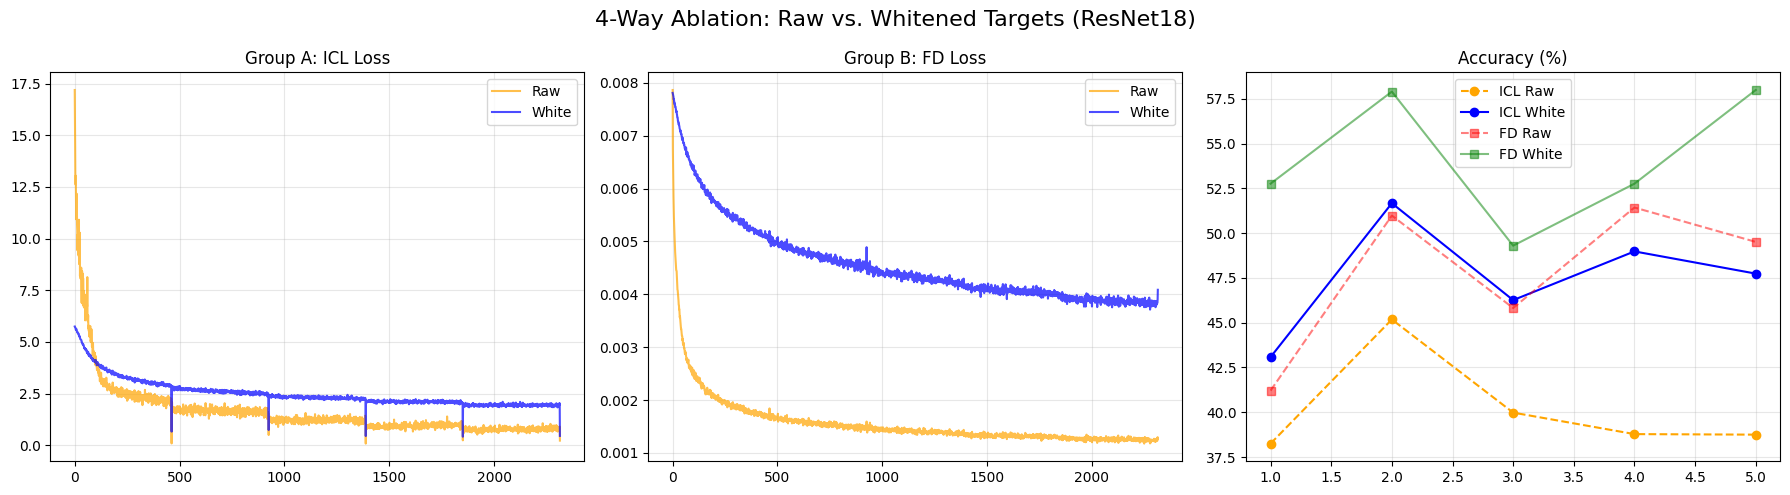

In [24]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- CONFIGURATION ---
EPOCHS = 5
ALPHA = 2000.0  # Weight for FD Loss
LR = 1e-4

# 1. Setup Optimizers
opt_icl_raw   = optim.AdamW(raw_icl_r18.parameters(),   lr=LR, weight_decay=0.1)
opt_icl_white = optim.AdamW(icl_white_r18.parameters(), lr=LR, weight_decay=0.1)
opt_fd_raw    = optim.AdamW(raw_fd_r18.parameters(),    lr=LR, weight_decay=0.1)
opt_fd_white  = optim.AdamW(fd_white_r18.parameters(),  lr=LR, weight_decay=0.1)

# 2. History
history = {
    "icl_raw":   {"loss": [], "acc": []},
    "icl_white": {"loss": [], "acc": []},
    "fd_raw":    {"loss": [], "acc": []},
    "fd_white":  {"loss": [], "acc": []}
}

# 3. Training Loop
print(f"🥊 STARTING 4-WAY BATTLE: ICL vs FD (Raw vs White)")

# Move Whitening Matrices
W_img, mean_img = W_img.to(device), mean_img.to(device)
W_txt, mean_txt = W_txt.to(device), mean_txt.to(device)

for epoch in range(EPOCHS):
    # Set all to train
    raw_icl_r18.train(); icl_white_r18.train()
    raw_fd_r18.train();  fd_white_r18.train()

    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (imgs, tokens, t_img_raw, t_txt_raw) in enumerate(pbar):
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_img_raw, t_txt_raw = t_img_raw.to(device), t_txt_raw.to(device)

        # --- PREPARE TARGETS ---
        with torch.no_grad():
            # A. Raw Targets
            t_v_raw = F.normalize(t_img_raw, p=2, dim=-1)
            t_t_raw = F.normalize(t_txt_raw, p=2, dim=-1)

            # B. Whitened Targets
            t_v_white = F.normalize((t_img_raw - mean_img) @ W_img, p=2, dim=-1)
            t_t_white = F.normalize((t_txt_raw - mean_txt) @ W_txt, p=2, dim=-1)

        # ==========================================
        # GROUP A: ICL MODELS
        # ==========================================

        # 1. ICL Raw
        opt_icl_raw.zero_grad()
        s_v, s_t, scale = raw_icl_r18(imgs, tokens) # Standard 3 unpack

        loss_nce = info_nce_loss(s_v, s_t)
        loss_icl = icl_loss(s_v, s_t, t_img_raw, t_txt_raw)

        (loss_nce + loss_icl).backward()
        opt_icl_raw.step()
        history["icl_raw"]["loss"].append(loss_icl.item())

        # 2. ICL White
        opt_icl_white.zero_grad()
        s_v, s_t, scale = icl_white_r18(imgs, tokens)

        loss_nce = info_nce_loss(s_v, s_t)
        loss_icl = icl_loss(s_v, s_t, t_v_white, t_t_white)

        (loss_nce + loss_icl).backward()
        opt_icl_white.step()
        history["icl_white"]["loss"].append(loss_icl.item())

        # ==========================================
        # GROUP B: FD MODELS
        # ==========================================

        # 3. FD Raw
        opt_fd_raw.zero_grad()
        s_v, s_t, scale = raw_fd_r18(imgs, tokens)

        loss_nce = info_nce_loss(s_v, s_t)
        loss_fd = fd_loss(F.normalize(s_v, dim=-1), t_v_raw) + \
                  fd_loss(F.normalize(s_t, dim=-1), t_t_raw)

        (loss_nce + ALPHA * loss_fd).backward()
        opt_fd_raw.step()
        history["fd_raw"]["loss"].append(loss_fd.item())

        # 4. FD White
        opt_fd_white.zero_grad()
        s_v, s_t, scale = fd_white_r18(imgs, tokens)

        loss_nce = info_nce_loss(s_v, s_t)
        loss_fd = fd_loss(F.normalize(s_v, dim=-1), t_v_white) + \
                  fd_loss(F.normalize(s_t, dim=-1), t_t_white)

        (loss_nce + ALPHA * loss_fd).backward()
        opt_fd_white.step()
        history["fd_white"]["loss"].append(loss_fd.item())

        if batch_idx % 10 == 0:
            pbar.set_postfix({
                "ICL_R": f"{history['icl_raw']['loss'][-1]:.2f}",
                "ICL_W": f"{history['icl_white']['loss'][-1]:.2f}",
                "FD_R":  f"{history['fd_raw']['loss'][-1]:.4f}",
                "FD_W":  f"{history['fd_white']['loss'][-1]:.4f}",
            })

    # ==========================================
    # 📊 EVALUATION
    # ==========================================
    print("\n⏱️ Epoch Finished. Running Evaluation...")

    # Eval all 4
    acc_icl_r = evaluate_on_cifar(raw_icl_r18, cifar_loader, device)
    acc_icl_w = evaluate_on_cifar(icl_white_r18, cifar_loader, device)
    acc_fd_r  = evaluate_on_cifar(raw_fd_r18, cifar_loader, device)
    acc_fd_w  = evaluate_on_cifar(fd_white_r18, cifar_loader, device)

    history["icl_raw"]["acc"].append(acc_icl_r)
    history["icl_white"]["acc"].append(acc_icl_w)
    history["fd_raw"]["acc"].append(acc_fd_r)
    history["fd_white"]["acc"].append(acc_fd_w)

    print("-" * 60)
    print(f"🏆 EPOCH {epoch+1} RESULTS")
    print(f"   Structure (ICL) | Raw: {acc_icl_r:.2f}% | White: {acc_icl_w:.2f}%")
    print(f"   Content   (FD)  | Raw: {acc_fd_r:.2f}%  | White: {acc_fd_w:.2f}%")
    print("-" * 60)

# --- 4. Plotting Results ---
print("📈 Plotting Loss Curves...")

def plot_4way_results(history):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('4-Way Ablation: Raw vs. Whitened Targets (ResNet18)', fontsize=16)

    # 1. ICL Loss
    axes[0].plot(history["icl_raw"]["loss"], label="Raw", color='orange', alpha=0.7)
    axes[0].plot(history["icl_white"]["loss"], label="White", color='blue', alpha=0.7)
    axes[0].set_title("Group A: ICL Loss")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. FD Loss
    axes[1].plot(history["fd_raw"]["loss"], label="Raw", color='orange', alpha=0.7)
    axes[1].plot(history["fd_white"]["loss"], label="White", color='blue', alpha=0.7)
    axes[1].set_title("Group B: FD Loss")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. Accuracy
    epochs = range(1, len(history["icl_raw"]["acc"]) + 1)
    axes[2].plot(epochs, history["icl_raw"]["acc"], 'o--', color='orange', label='ICL Raw')
    axes[2].plot(epochs, history["icl_white"]["acc"], 'o-', color='blue', label='ICL White')
    axes[2].plot(epochs, history["fd_raw"]["acc"], 's--', color='red', label='FD Raw', alpha=0.5)
    axes[2].plot(epochs, history["fd_white"]["acc"], 's-', color='green', label='FD White', alpha=0.5)

    axes[2].set_title("Accuracy (%)")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_4way_results(history)

Resnet Training

In [25]:
from google.colab import drive
import os
import torch

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Create the Destination Folder
save_path = '/content/drive/MyDrive/CLIPResnet'
os.makedirs(save_path, exist_ok=True)
print(f"📂 Saving models to: {save_path}")

# 3. List of potential models to save
# We use a dictionary to map filename -> model object
models_to_save = {
    # From 2-Way Battle
    'resnet_raw_baseline.pth': 'student_r18',
    'resnet_white_ours.pth':   'student_white_r18',

    # From 4-Way Ablation
    'resnet_icl_raw.pth':      'raw_icl_r18',
    'resnet_icl_white.pth':    'icl_white_r18',
    'resnet_fd_raw.pth':       'raw_fd_r18',
    'resnet_fd_white.pth':     'fd_white_r18'
}

# 4. Save Loop
count = 0
for filename, var_name in models_to_save.items():
    # Check if the model variable exists in your current session
    if var_name in globals():
        model = globals()[var_name]
        full_path = os.path.join(save_path, filename)

        # Save only the weights (state_dict) to save space
        torch.save(model.state_dict(), full_path)
        print(f"✅ Saved: {filename}")
        count += 1
    else:
        print(f"⚠️ Skipped: {var_name} (Model not found in memory)")

print(f"\n🎉 Process Complete. {count} models saved to Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Saving models to: /content/drive/MyDrive/CLIPResnet
✅ Saved: resnet_raw_baseline.pth
✅ Saved: resnet_white_ours.pth
✅ Saved: resnet_icl_raw.pth
✅ Saved: resnet_icl_white.pth
✅ Saved: resnet_fd_raw.pth
✅ Saved: resnet_fd_white.pth

🎉 Process Complete. 6 models saved to Drive.


🎲 Sampling 1000 random datapoints for fair comparison...

🚀 Running Full Evaluation Suite on ResNet Models...
   > Evaluating: Teacher...
   > Evaluating: Student (Raw)...
   > Evaluating: Student (White)...
   > Evaluating: ICL (Raw)...
   > Evaluating: ICL (White)...
   > Evaluating: FD (Raw)...
   > Evaluating: FD (White)...

📊 FINAL REPORT CARD (ResNet18):
          Model Accuracy (%) Rank (Img) Modal Gap Drift (MSE)
        Teacher         0.00     327.25    0.7816      0.0000
  Student (Raw)        56.71     185.36    0.8838      0.0010
Student (White)        56.96     271.78    0.1229      0.0020
      ICL (Raw)        38.75     212.63    0.2981      0.0031
    ICL (White)        47.74     235.56    0.1508      0.0025
       FD (Raw)        49.51     172.65    0.7743      0.0008
     FD (White)        57.99     274.17    0.1255      0.0020

🎨 Generating Dashboard (Dual-Modality t-SNE + Spectrum)...
   ... Computing t-SNE (Images + Text)
   ... Computing Correlations
   ... Compu

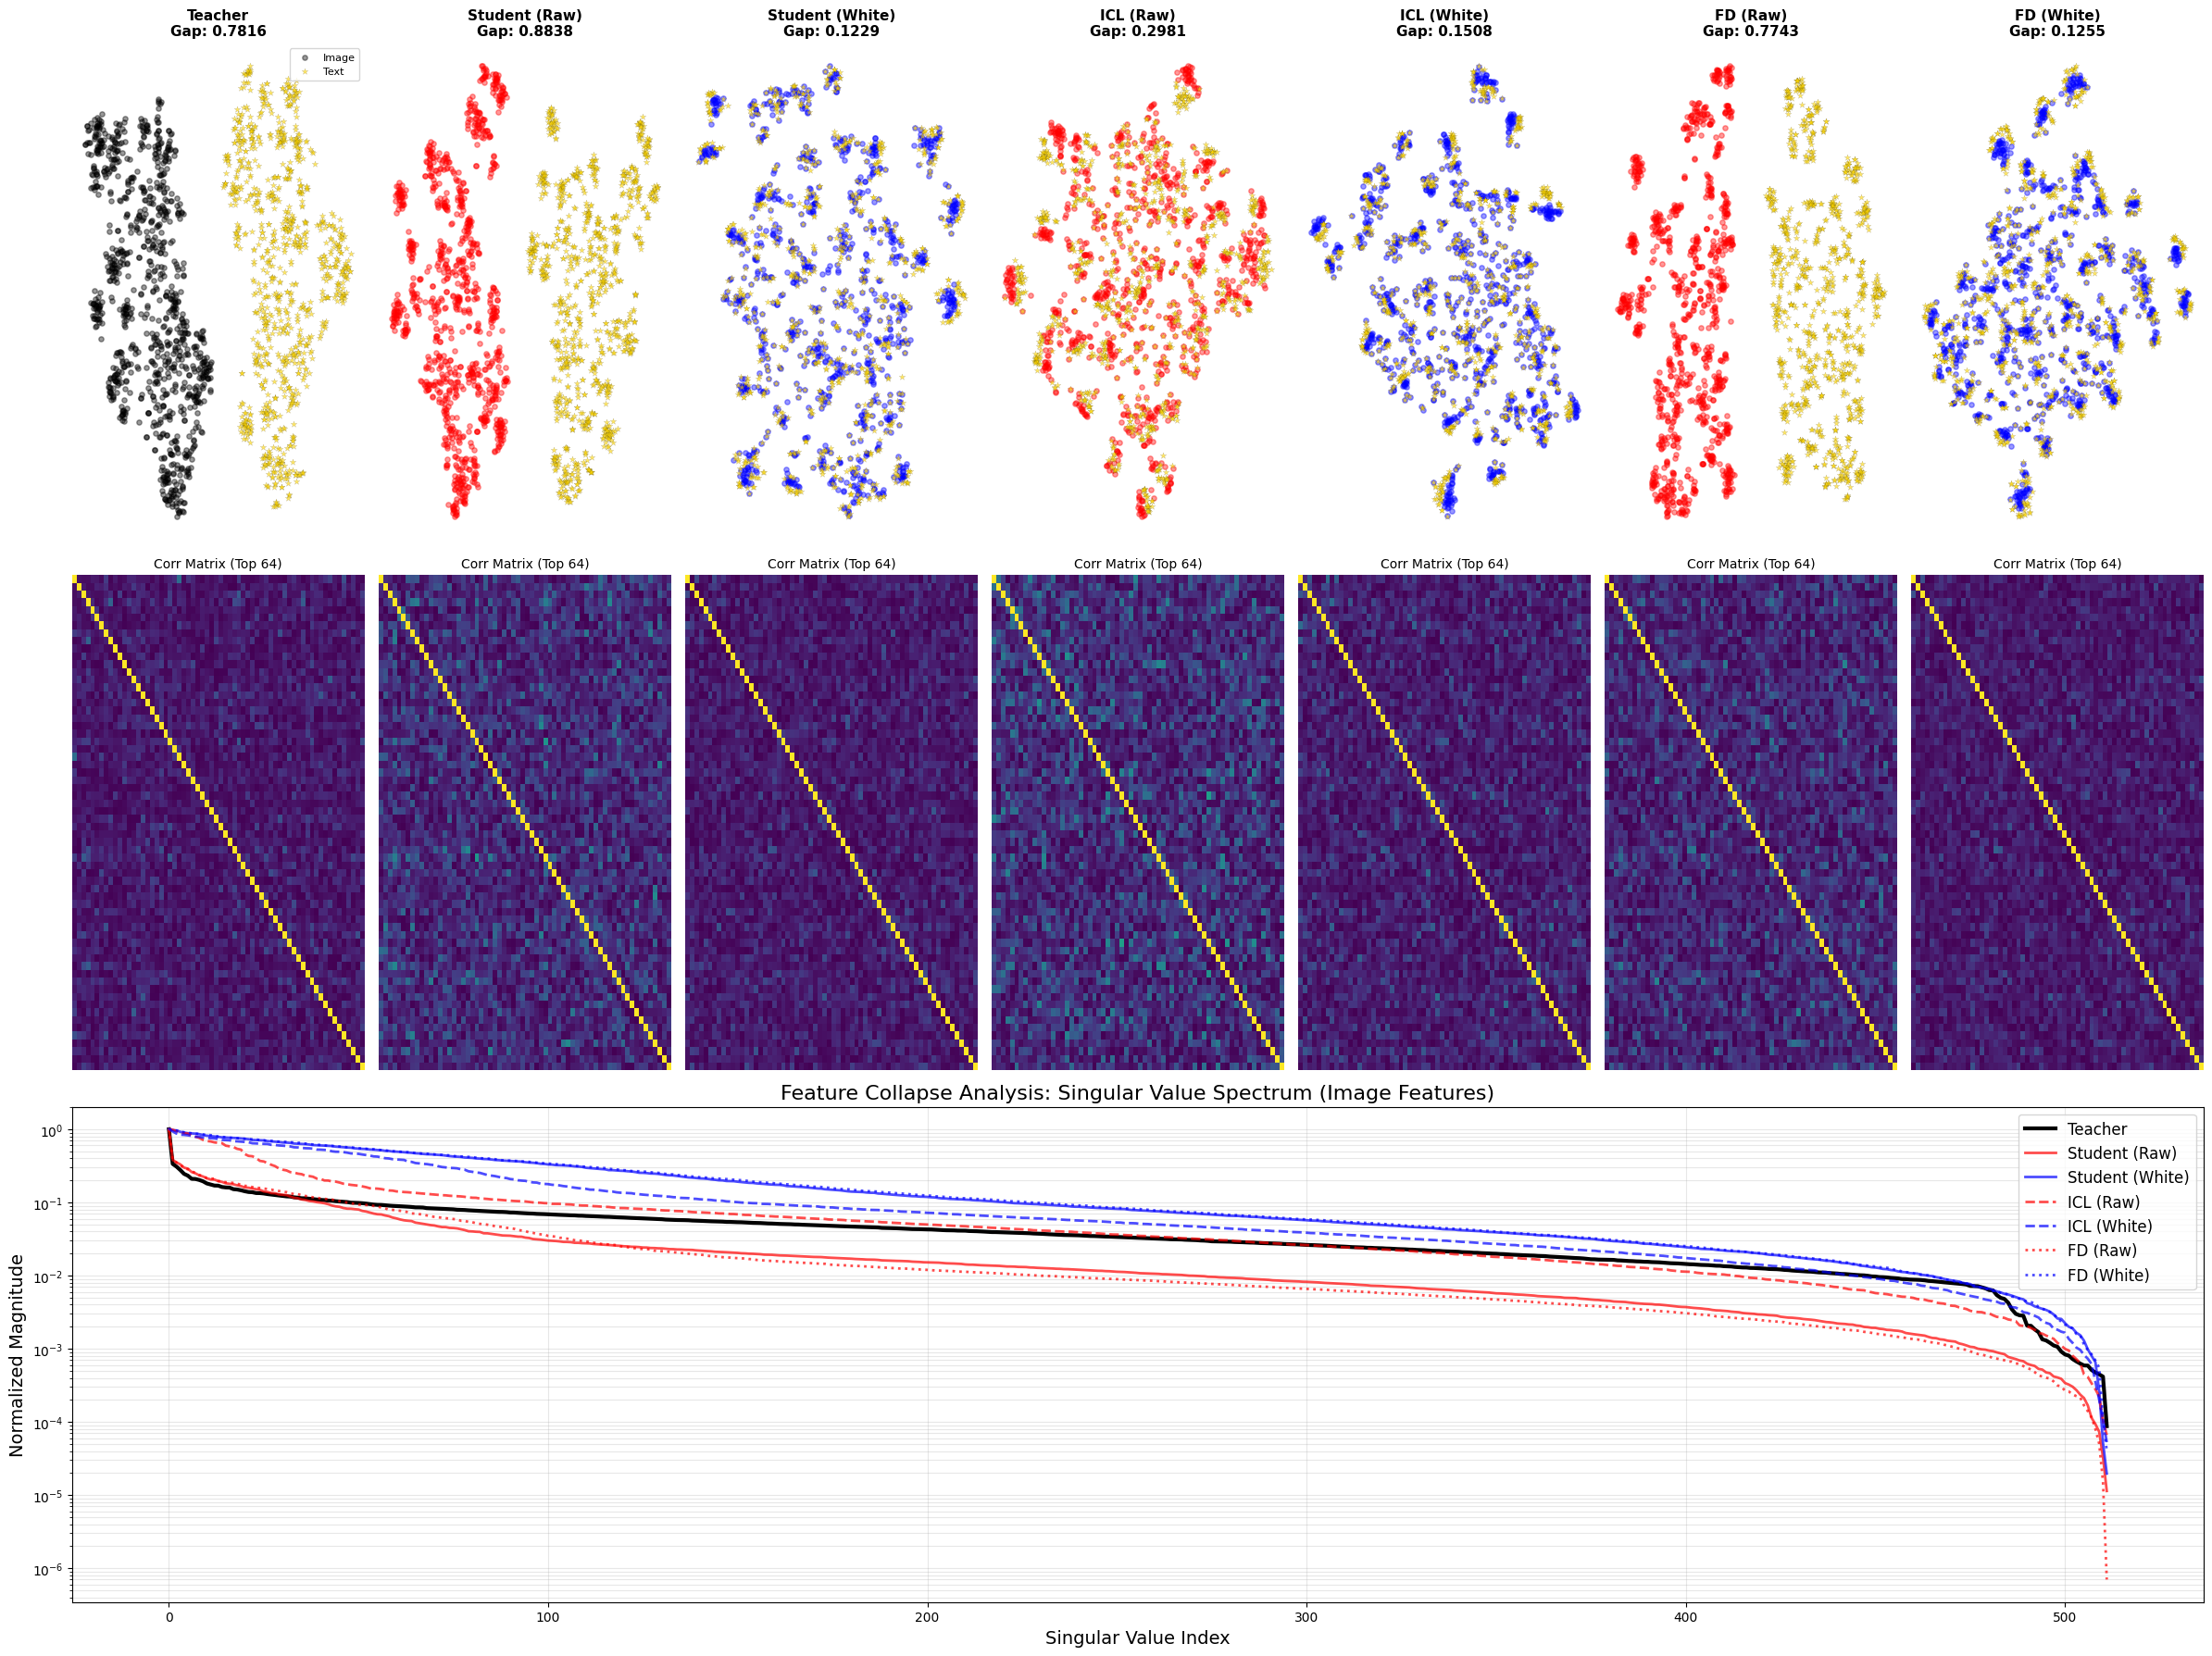

✅ Visualization Complete.


In [27]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import Subset
import seaborn as sns

# --- 1. CONFIGURATION ---
NUM_SAMPLES = 1000  # Smaller sample for t-SNE speed
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define ResNet Model Registry
models_dict = {
    "Teacher": teacher,
    "Student (Raw)": student_r18,
    "Student (White)": student_white_r18,
    "ICL (Raw)": raw_icl_r18,
    "ICL (White)": icl_white_r18,
    "FD (Raw)": raw_fd_r18,
    "FD (White)": fd_white_r18
}

# --- 2. PREPARE FIXED DATASET ---
print(f"🎲 Sampling {NUM_SAMPLES} random datapoints for fair comparison...")

indices = torch.randperm(len(student_loader.dataset))[:NUM_SAMPLES]
subset = Subset(student_loader.dataset, indices)
eval_loader = torch.utils.data.DataLoader(subset, batch_size=256, shuffle=False)

# Pre-Compute Teacher Ground Truth (for Drift Calculation)
teacher_img_gt = []
with torch.no_grad():
    for imgs, tokens, t_img, t_txt in eval_loader:
        teacher_img_gt.append(t_img.to(DEVICE))
teacher_img_gt = torch.cat(teacher_img_gt)

# --- 3. METRIC FUNCTIONS ---
def compute_effective_rank(features):
    features = F.normalize(features, p=2, dim=-1)
    _, S, _ = torch.linalg.svd(features)
    p = S / S.sum()
    entropy = -torch.sum(p * torch.log(p + 1e-6))
    return torch.exp(entropy).item()

def compute_modal_gap(img_feats, txt_feats):
    img_center = img_feats.mean(dim=0)
    txt_center = txt_feats.mean(dim=0)
    return torch.norm(img_center - txt_center, p=2).item()

def compute_ts_distance(s_feats, t_feats):
    s_norm = F.normalize(s_feats, p=2, dim=-1)
    t_norm = F.normalize(t_feats, p=2, dim=-1)
    return F.mse_loss(s_norm, t_norm).item()

# --- 4. MAIN EVALUATION LOOP ---
results = []
feature_bank = {} # Store tuples of (img_feats, txt_feats)

print("\n🚀 Running Full Evaluation Suite on ResNet Models...")

for name, model in models_dict.items():
    print(f"   > Evaluating: {name}...")
    model.eval()

    # A. Accuracy
    if name == "Teacher":
        acc = 0.0
    else:
        acc = evaluate_on_cifar(model, cifar_loader, DEVICE)

    # B. Extract Features
    all_v = []
    all_t = []

    with torch.no_grad():
        for imgs, tokens, _, _ in eval_loader:
            imgs, tokens = imgs.to(DEVICE), tokens.to(DEVICE)

            if name == "Teacher":
                v = model.encode_image(imgs)
                t = model.encode_text(tokens)
            else:
                v, t, _ = model(imgs, tokens)

            all_v.append(v)
            all_t.append(t)

    all_v = torch.cat(all_v)
    all_t = torch.cat(all_t)

    # Normalize
    all_v_norm = F.normalize(all_v, p=2, dim=-1)
    all_t_norm = F.normalize(all_t, p=2, dim=-1)

    # Store BOTH modalities for t-SNE
    feature_bank[name] = (all_v_norm.cpu(), all_t_norm.cpu())

    # C. Compute Metrics
    rank_v = compute_effective_rank(all_v)
    gap = compute_modal_gap(all_v_norm, all_t_norm)

    if name == "Teacher":
        dist = 0.0
    else:
        dist = compute_ts_distance(all_v, teacher_img_gt)

    results.append({
        "Model": name,
        "Accuracy (%)": f"{acc:.2f}",
        "Rank (Img)": f"{rank_v:.2f}",
        "Modal Gap": f"{gap:.4f}",
        "Drift (MSE)": f"{dist:.4f}"
    })

# --- 5. PRINT TABLE ---
df = pd.DataFrame(results)
print("\n📊 FINAL REPORT CARD (ResNet18):")
print(df.to_string(index=False))

# --- 6. VISUALIZATION DASHBOARD ---
print("\n🎨 Generating Dashboard (Dual-Modality t-SNE + Spectrum)...")

fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 7)

# A. t-SNE PLOTS (Top Row)
print("   ... Computing t-SNE (Images + Text)")

for i, (name, (img_feats, txt_feats)) in enumerate(feature_bank.items()):
    ax = fig.add_subplot(gs[0, i])

    # 1. Concatenate for Joint t-SNE
    # We map them together to see the gap in the same space
    combined = torch.cat([img_feats, txt_feats], dim=0)
    labels = np.array([0] * len(img_feats) + [1] * len(txt_feats)) # 0=Image, 1=Text

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    proj = tsne.fit_transform(combined.numpy())

    # Split back
    proj_img = proj[labels == 0]
    proj_txt = proj[labels == 1]

    # Color coding logic
    color_img = 'gray'
    if "Teacher" in name: color_img = 'black'
    elif "White" in name: color_img = 'blue'
    elif "Raw" in name:   color_img = 'red'

    # Plot Images (Circles)
    ax.scatter(proj_img[:, 0], proj_img[:, 1], alpha=0.4, s=15,
               c=color_img, marker='o', label='Image')

    # Plot Text (Stars/Triangles)
    # We make text 'gold' or 'orange' to stand out against the blue/red/black
    ax.scatter(proj_txt[:, 0], proj_txt[:, 1], alpha=0.6, s=25,
               c='gold', marker='*', edgecolors='black', linewidth=0.1, label='Text')

    gap_val = df.loc[df['Model']==name, 'Modal Gap'].values[0]
    ax.set_title(f"{name}\nGap: {gap_val}", fontsize=11, fontweight='bold')
    if i == 0: ax.legend(fontsize=8) # Only legend on first plot
    ax.axis('off')

# B. CORRELATION HEATMAPS (Middle Row - Images Only)
print("   ... Computing Correlations")
for i, (name, (img_feats, _)) in enumerate(feature_bank.items()):
    ax = fig.add_subplot(gs[1, i])
    corr_matrix = torch.corrcoef(img_feats.T).abs().numpy()
    sns.heatmap(corr_matrix[:64, :64], ax=ax, cmap="viridis", cbar=False, vmin=0, vmax=1)
    ax.set_title(f"Corr Matrix (Top 64)", fontsize=10)
    ax.axis('off')

# C. SPECTRAL DENSITY (Bottom Row - Images Only)
print("   ... Computing Spectral Density")
ax_spec = fig.add_subplot(gs[2, :])

colors_map = {'Teacher': 'black', 'Raw': 'red', 'White': 'blue'}
styles_map = {'Teacher': '-', 'Student': '-', 'ICL': '--', 'FD': ':'}

for name, (img_feats, _) in feature_bank.items():
    _, S, _ = torch.linalg.svd(img_feats)
    S = S / S.max()

    c = 'gray'
    if "Teacher" in name: c = colors_map['Teacher']
    elif "Raw" in name:   c = colors_map['Raw']
    elif "White" in name: c = colors_map['White']

    ls = '-'
    if "ICL" in name: ls = styles_map['ICL']
    elif "FD" in name: ls = styles_map['FD']

    lw = 3 if name == "Teacher" else 2
    alpha = 1.0 if name == "Teacher" else 0.7

    ax_spec.plot(S.numpy(), label=name, color=c, linestyle=ls, linewidth=lw, alpha=alpha)

ax_spec.set_yscale('log')
ax_spec.set_title("Feature Collapse Analysis: Singular Value Spectrum (Image Features)", fontsize=16)
ax_spec.set_xlabel("Singular Value Index", fontsize=14)
ax_spec.set_ylabel("Normalized Magnitude", fontsize=14)
ax_spec.legend(fontsize=12)
ax_spec.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
print("✅ Visualization Complete.")

🎲 Sampling 1000 random datapoints for fair comparison...

🚀 Running Full Evaluation Suite on ResNet Models...
   > Evaluating: Teacher...
   > Evaluating: Student (Raw)...
   > Evaluating: Student (White)...
   > Evaluating: ICL (Raw)...
   > Evaluating: ICL (White)...
   > Evaluating: FD (Raw)...
   > Evaluating: FD (White)...

📊 FINAL REPORT CARD (ResNet18):
          Model ZS Acc (%) I2T Acc (%) T2I Acc (%)   Rank    Gap  Drift
        Teacher       0.00       61.30       58.60 328.28 0.7805 0.0000
  Student (Raw)      56.71       60.30       54.60 185.10 0.8863 0.0010
Student (White)      56.96       69.30       68.60 271.87 0.1226 0.0020
      ICL (Raw)      38.75       65.60       59.70 212.08 0.3008 0.0031
    ICL (White)      47.74       72.30       69.10 235.82 0.1512 0.0025
       FD (Raw)      49.51       65.80       65.00 172.79 0.7738 0.0008
     FD (White)      57.99       67.00       68.40 274.35 0.1244 0.0020

🎨 Generating Dashboard...
   ... Computing t-SNE
   ... Comp

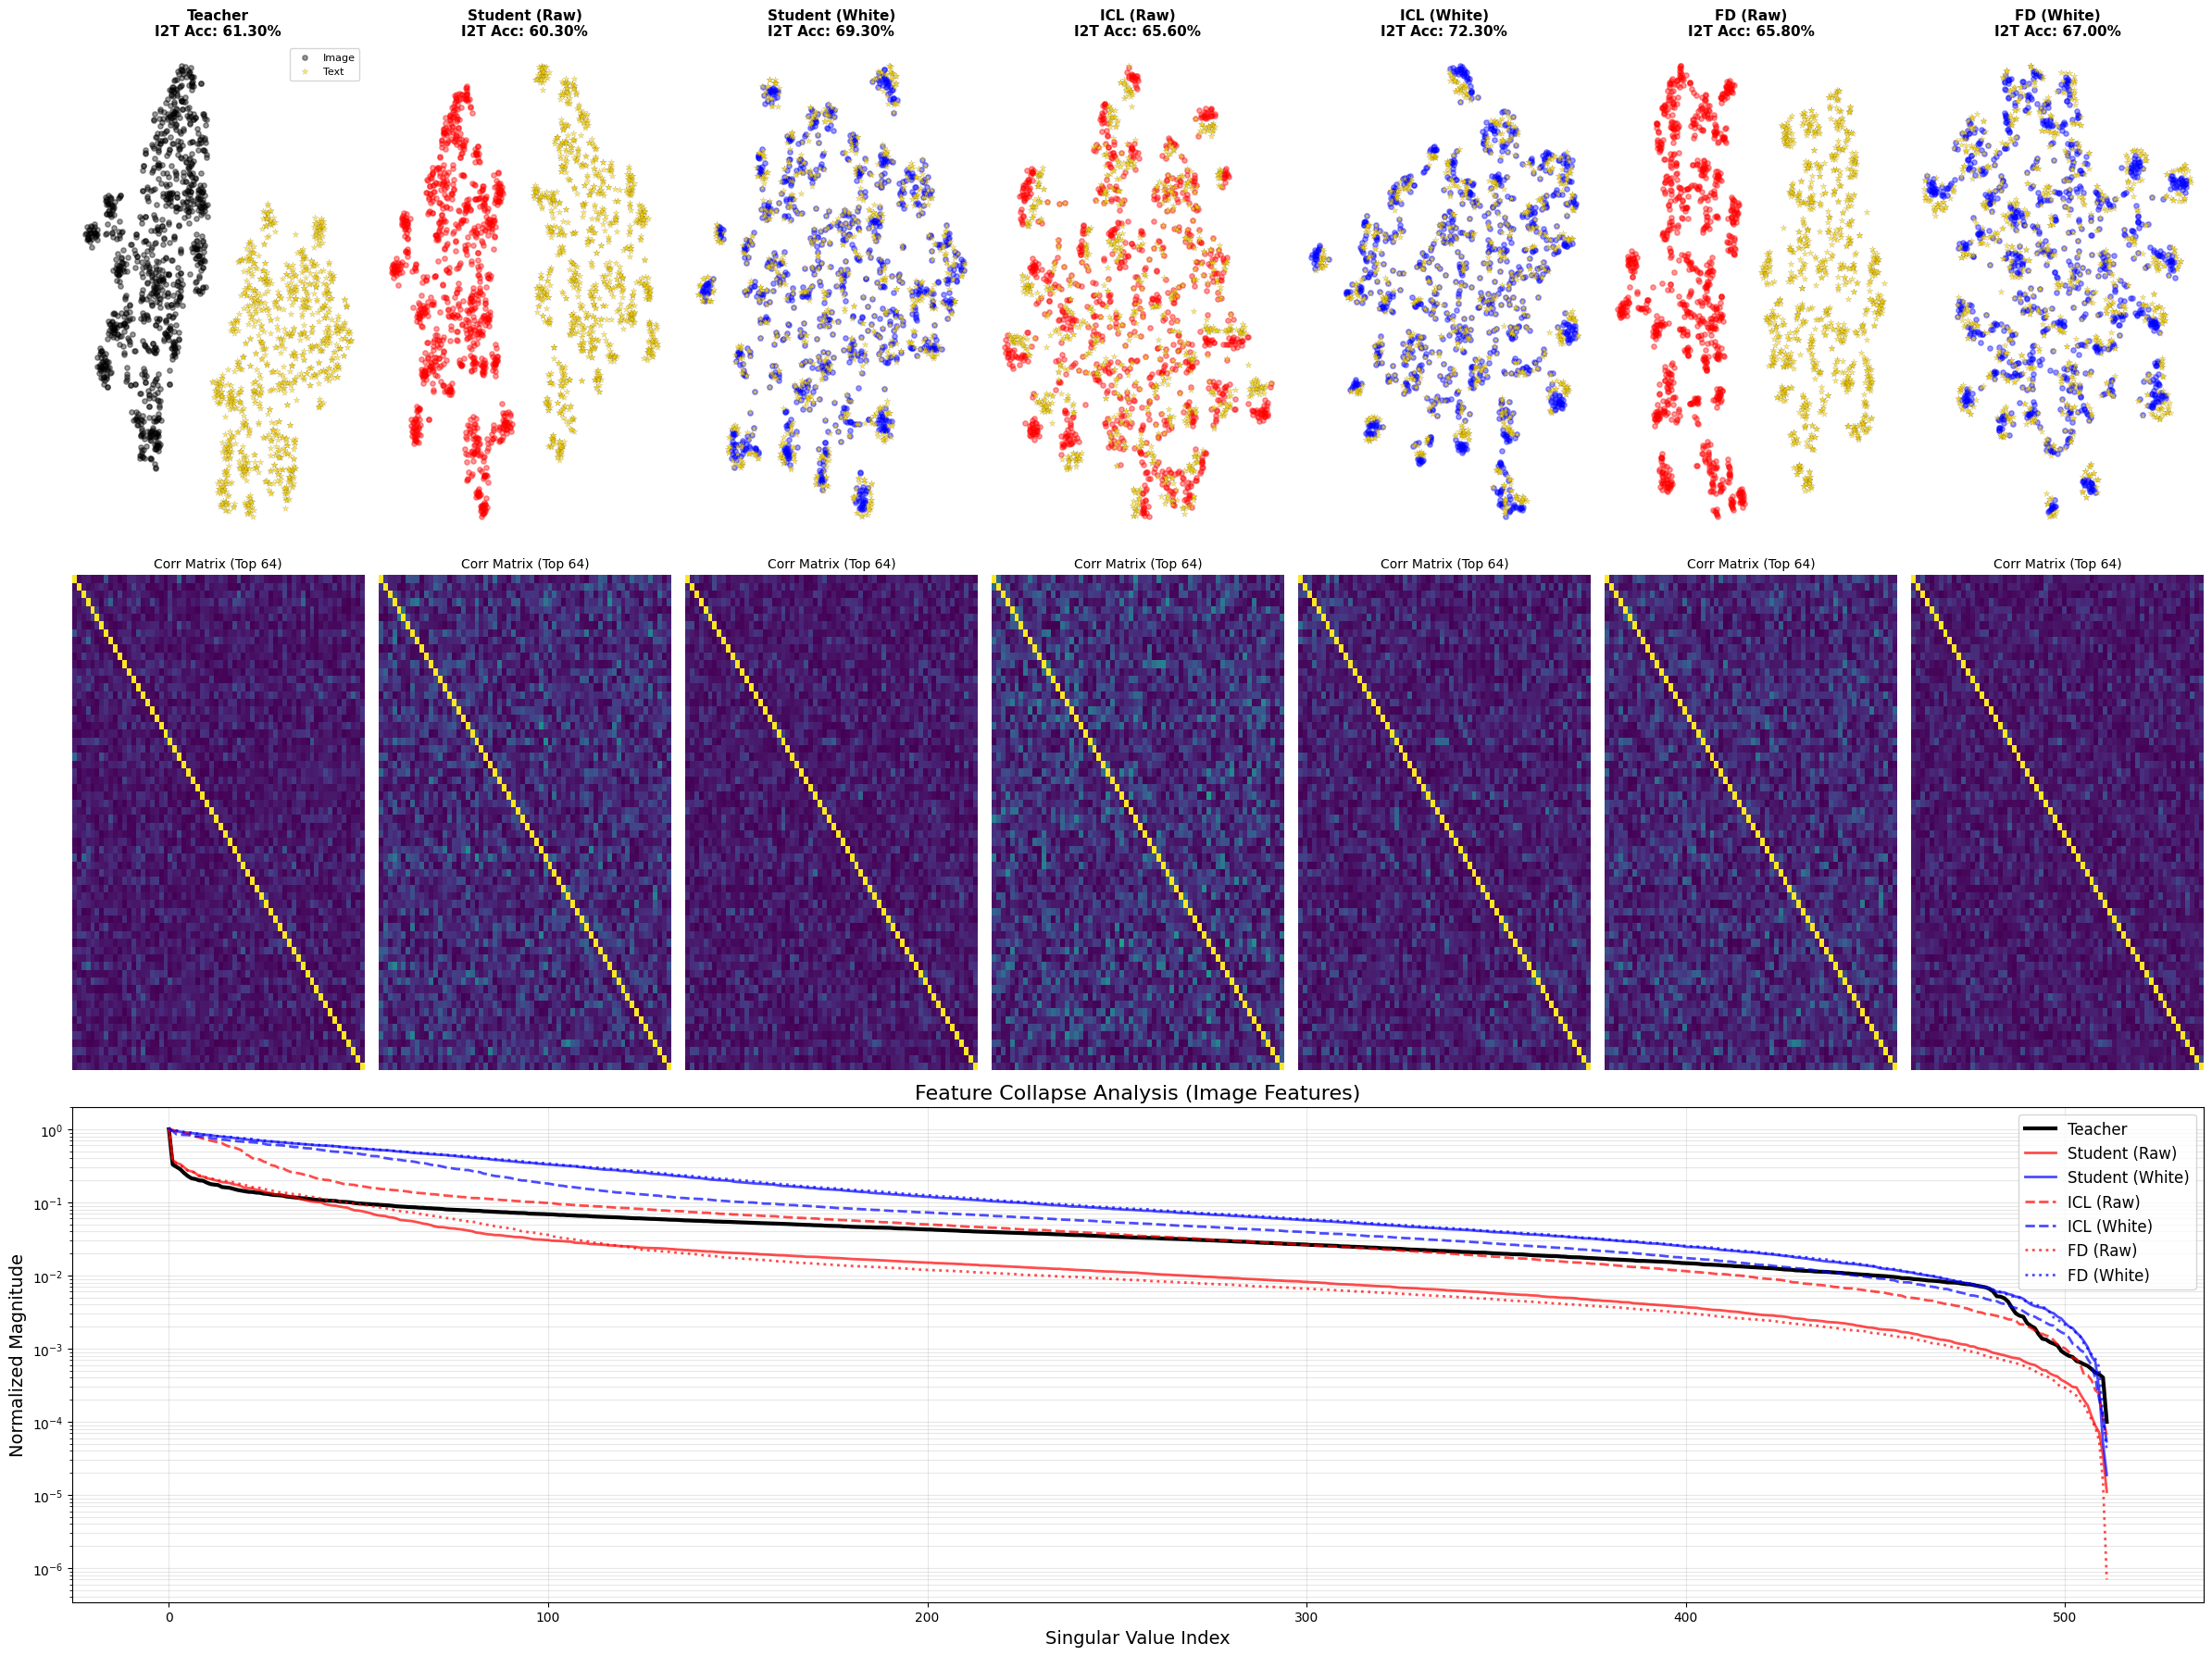

✅ Visualization Complete.


In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import Subset
import seaborn as sns

# --- 1. CONFIGURATION ---
NUM_SAMPLES = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define ResNet Model Registry
models_dict = {
    "Teacher": teacher,
    "Student (Raw)": student_r18,
    "Student (White)": student_white_r18,
    "ICL (Raw)": raw_icl_r18,
    "ICL (White)": icl_white_r18,
    "FD (Raw)": raw_fd_r18,
    "FD (White)": fd_white_r18
}

# --- 2. PREPARE FIXED DATASET ---
print(f"🎲 Sampling {NUM_SAMPLES} random datapoints for fair comparison...")

indices = torch.randperm(len(student_loader.dataset))[:NUM_SAMPLES]
subset = Subset(student_loader.dataset, indices)
eval_loader = torch.utils.data.DataLoader(subset, batch_size=256, shuffle=False)

# Pre-Compute Teacher Ground Truth (for Drift Calculation)
teacher_img_gt = []
with torch.no_grad():
    for imgs, tokens, t_img, t_txt in eval_loader:
        teacher_img_gt.append(t_img.to(DEVICE))
teacher_img_gt = torch.cat(teacher_img_gt)

# --- 3. METRIC FUNCTIONS ---
def compute_effective_rank(features):
    features = F.normalize(features, p=2, dim=-1)
    _, S, _ = torch.linalg.svd(features)
    p = S / S.sum()
    entropy = -torch.sum(p * torch.log(p + 1e-6))
    return torch.exp(entropy).item()

def compute_modal_gap(img_feats, txt_feats):
    img_center = img_feats.mean(dim=0)
    txt_center = txt_feats.mean(dim=0)
    return torch.norm(img_center - txt_center, p=2).item()

def compute_ts_distance(s_feats, t_feats):
    s_norm = F.normalize(s_feats, p=2, dim=-1)
    t_norm = F.normalize(t_feats, p=2, dim=-1)
    return F.mse_loss(s_norm, t_norm).item()

def compute_retrieval_accuracy(img_feats, txt_feats):
    """
    Computes Nearest Neighbor Accuracy (Recall@1) for both directions.
    Assumes features are already normalized and aligned (i.e., img[i] matches txt[i]).
    """
    # Similarity Matrix: (N, N)
    # entry [i, j] is similarity between image i and text j
    logits = img_feats @ txt_feats.t()

    batch_size = logits.shape[0]
    labels = torch.arange(batch_size, device=logits.device)

    # Image-to-Text: For each image, is the correct text the closest?
    i2t_preds = logits.argmax(dim=1)
    i2t_acc = (i2t_preds == labels).float().mean().item()

    # Text-to-Image: For each text, is the correct image the closest?
    t2i_preds = logits.argmax(dim=0)
    t2i_acc = (t2i_preds == labels).float().mean().item()

    return i2t_acc * 100, t2i_acc * 100

# --- 4. MAIN EVALUATION LOOP ---
results = []
feature_bank = {}

print("\n🚀 Running Full Evaluation Suite on ResNet Models...")

for name, model in models_dict.items():
    print(f"   > Evaluating: {name}...")
    model.eval()

    # A. Accuracy (Zero-Shot Classification)
    if name == "Teacher":
        zs_acc = 0.0
    else:
        zs_acc = evaluate_on_cifar(model, cifar_loader, DEVICE)

    # B. Extract Features
    all_v = []
    all_t = []

    with torch.no_grad():
        for imgs, tokens, _, _ in eval_loader:
            imgs, tokens = imgs.to(DEVICE), tokens.to(DEVICE)

            if name == "Teacher":
                v = model.encode_image(imgs)
                t = model.encode_text(tokens)
            else:
                v, t, _ = model(imgs, tokens)

            all_v.append(v)
            all_t.append(t)

    all_v = torch.cat(all_v)
    all_t = torch.cat(all_t)

    # Normalize
    all_v_norm = F.normalize(all_v, p=2, dim=-1)
    all_t_norm = F.normalize(all_t, p=2, dim=-1)

    # Store for t-SNE
    feature_bank[name] = (all_v_norm.cpu(), all_t_norm.cpu())

    # C. Compute Metrics
    rank_v = compute_effective_rank(all_v)
    gap = compute_modal_gap(all_v_norm, all_t_norm)

    # D. Retrieval Accuracy (NEW)
    i2t, t2i = compute_retrieval_accuracy(all_v_norm, all_t_norm)

    if name == "Teacher":
        dist = 0.0
    else:
        dist = compute_ts_distance(all_v, teacher_img_gt)

    results.append({
        "Model": name,
        "ZS Acc (%)": f"{zs_acc:.2f}",
        "I2T Acc (%)": f"{i2t:.2f}",
        "T2I Acc (%)": f"{t2i:.2f}",
        "Rank": f"{rank_v:.2f}",
        "Gap": f"{gap:.4f}",
        "Drift": f"{dist:.4f}"
    })

# --- 5. PRINT TABLE ---
df = pd.DataFrame(results)
print("\n📊 FINAL REPORT CARD (ResNet18):")
print(df.to_string(index=False))

# --- 6. VISUALIZATION DASHBOARD ---
print("\n🎨 Generating Dashboard...")

fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 7)

# A. t-SNE PLOTS (Top Row)
print("   ... Computing t-SNE")
for i, (name, (img_feats, txt_feats)) in enumerate(feature_bank.items()):
    ax = fig.add_subplot(gs[0, i])

    combined = torch.cat([img_feats, txt_feats], dim=0)
    labels = np.array([0] * len(img_feats) + [1] * len(txt_feats))

    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    proj = tsne.fit_transform(combined.numpy())

    proj_img = proj[labels == 0]
    proj_txt = proj[labels == 1]

    color_img = 'gray'
    if "Teacher" in name: color_img = 'black'
    elif "White" in name: color_img = 'blue'
    elif "Raw" in name:   color_img = 'red'

    ax.scatter(proj_img[:, 0], proj_img[:, 1], alpha=0.4, s=15,
               c=color_img, marker='o', label='Image')

    ax.scatter(proj_txt[:, 0], proj_txt[:, 1], alpha=0.6, s=25,
               c='gold', marker='*', edgecolors='black', linewidth=0.1, label='Text')

    # Display I2T Acc in title
    i2t_val = df.loc[df['Model']==name, 'I2T Acc (%)'].values[0]
    ax.set_title(f"{name}\nI2T Acc: {i2t_val}%", fontsize=11, fontweight='bold')
    if i == 0: ax.legend(fontsize=8)
    ax.axis('off')

# B. CORRELATION HEATMAPS (Middle Row)
print("   ... Computing Correlations")
for i, (name, (img_feats, _)) in enumerate(feature_bank.items()):
    ax = fig.add_subplot(gs[1, i])
    corr_matrix = torch.corrcoef(img_feats.T).abs().numpy()
    sns.heatmap(corr_matrix[:64, :64], ax=ax, cmap="viridis", cbar=False, vmin=0, vmax=1)
    ax.set_title(f"Corr Matrix (Top 64)", fontsize=10)
    ax.axis('off')

# C. SPECTRAL DENSITY (Bottom Row)
print("   ... Computing Spectral Density")
ax_spec = fig.add_subplot(gs[2, :])

colors_map = {'Teacher': 'black', 'Raw': 'red', 'White': 'blue'}
styles_map = {'Teacher': '-', 'Student': '-', 'ICL': '--', 'FD': ':'}

for name, (img_feats, _) in feature_bank.items():
    _, S, _ = torch.linalg.svd(img_feats)
    S = S / S.max()

    c = 'gray'
    if "Teacher" in name: c = colors_map['Teacher']
    elif "Raw" in name:   c = colors_map['Raw']
    elif "White" in name: c = colors_map['White']

    ls = '-'
    if "ICL" in name: ls = styles_map['ICL']
    elif "FD" in name: ls = styles_map['FD']

    lw = 3 if name == "Teacher" else 2
    alpha = 1.0 if name == "Teacher" else 0.7

    ax_spec.plot(S.numpy(), label=name, color=c, linestyle=ls, linewidth=lw, alpha=alpha)

ax_spec.set_yscale('log')
ax_spec.set_title("Feature Collapse Analysis (Image Features)", fontsize=16)
ax_spec.set_xlabel("Singular Value Index", fontsize=14)
ax_spec.set_ylabel("Normalized Magnitude", fontsize=14)
ax_spec.legend(fontsize=12)
ax_spec.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
print("✅ Visualization Complete.")